# General $F \rightarrow F'$ 3D MOTs

This example covers calculating the forces in both type-I and type-II three-dimensional MOTs.  In particular, we are trying to reproduce the results of M.R. Tarbutt, “Magneto-optical trapping forces for atoms and molecules with complex level structures” *New Journal of Physics* **17**, 015007 (2015) http://dx.doi.org/10.1088/1367-2630/17/1/015007

We also take a look at what a subset of these MOTs look like as a function of both $\mathbf{v}$ and $\mathbf{r}$ as well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

### First, can we reproduce all the figures?

In the reference above, the forces for a variety of $F\rightarrow F'$ MOTs are calculated for a variety of different upper state $g_u$-factors and three lower state $g_l$-factors.

Note that we turn of the magnetic forces for `rateeq` because we are using the same unit system as that in `01_F0_to_F1_1D_MOT_capture.ipynb`.  Here, we are not calculating any dynamics.

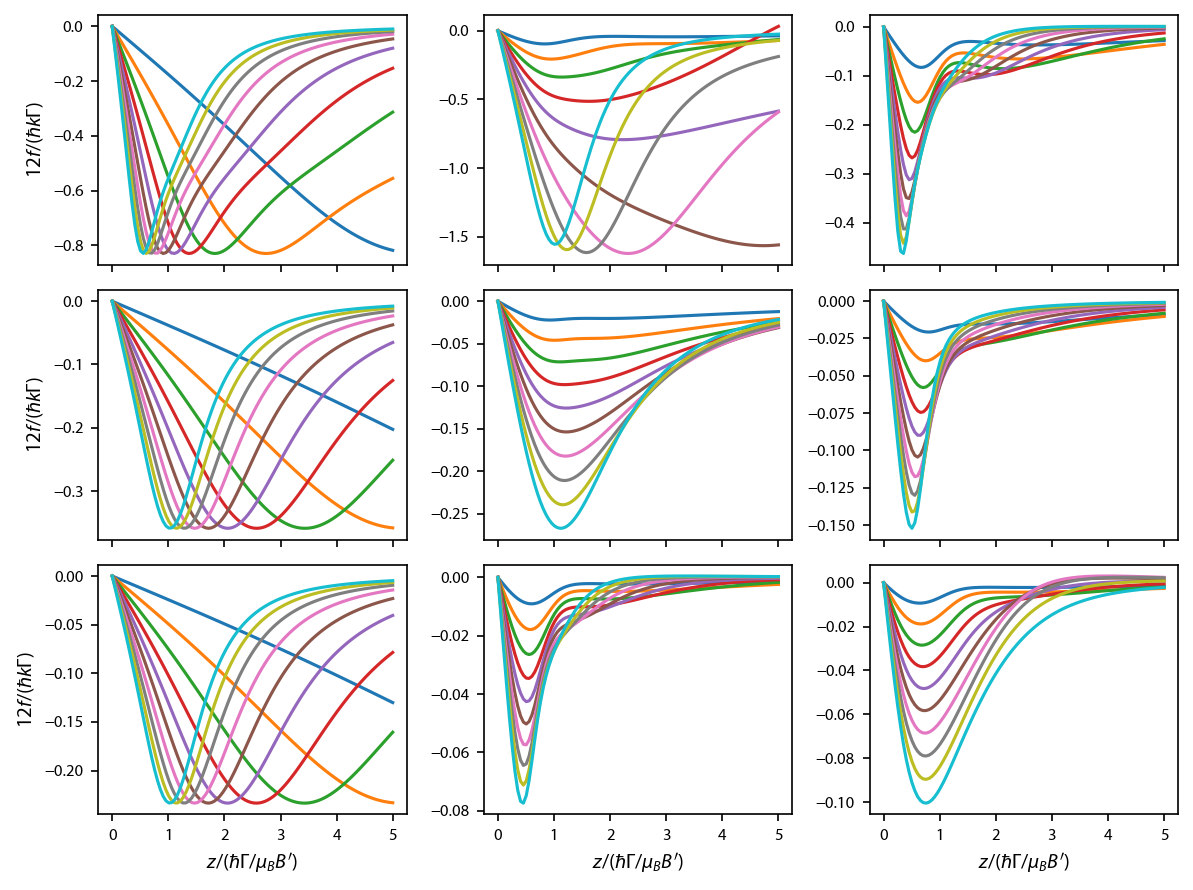

In [2]:
det = -1.0
s = 1.0

# Make a z-axis
z = np.linspace(1e-10, 5, 100)

# Make the figure
fig, ax = plt.subplots(3, 3,figsize=(9, 6.5))

# Define the lasers:
laserBeams = pylcp.conventional3DMOTBeams(delta=det, s=s,
                                          beam_type=pylcp.infinitePlaneWaveBeam)
# Define the magnetic field
magField = pylcp.quadrupoleMagneticField(1.)

Fs = [[1, 2], [1, 1], [2, 1]] # The Fs we want to run through
gl = np.array([0., 1., -1.])  # The lower state g factors to run
gu = np.arange(0.1, 1.1, 0.1) # The upper state g factors to run
for jj, (Fl, Fu) in enumerate(Fs):
    for ii, gl_i in enumerate(gl):
        for gu_i in gu:
            # Case 1: F=1 -> F=2
            Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=gl_i, muB=1)
            if Fu<Fl: # Reverse the upper state g-factor to get a confining force
                He, Beq = pylcp.hamiltonians.singleF(F=Fu, gF=-gu_i, muB=1)
            else: 
                He, Beq = pylcp.hamiltonians.singleF(F=Fu, gF=gu_i, muB=1)

            dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, Fu)

            hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq)

            rateeq = pylcp.rateeq(laserBeams, magField, hamiltonian,
                                  svd_eps=1e-10, include_mag_forces=False)
            
            rateeq.generate_force_profile(
                [np.zeros(z.shape), np.zeros(z.shape), z],
                [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
                name='Fz')
            Fz = rateeq.profile['Fz'].F[2]

            ax[jj, ii].plot(z, 12*Fz)
            if jj<2:
                ax[jj, ii].xaxis.set_ticklabels([])

for ii in range(3):
    ax[ii, 0].set_ylabel('$12f/(\hbar k \Gamma)$')
    ax[2, ii].set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')
fig.subplots_adjust(wspace=0.25)

The rows correspond to (top to bottom) $F=1\rightarrow F'=2$, $F=1\rightarrow F'=1$, and $F=2\rightarrow F'=1$, respectively.  The columns correspond to $g_l= 0., 1., -1.$, from left to right.  Note that we use normalized units here, unlike in the reference, which uses lab units.  They also use a Gaussian beam with a width defined in lab units, while we use infinite plane-wave beams.  That accounts for the slight differences at large $z$.

### Now let's look at the force in phase space:

We'll constrict ourselves to $g_l=0$ and $g_u = 1/F'$.

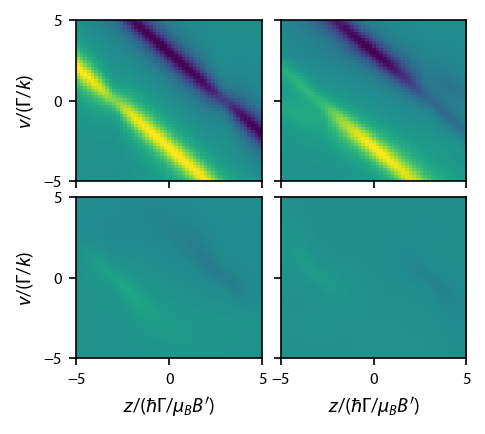

In [3]:
x = np.arange(-5, 5.1, 0.2)
v = np.arange(-5, 5.1, 0.2)

X, V = np.meshgrid(x, v)

det = -3.0
alpha = 1.0
s = 2.0

# Definte laser beams and magnetic field again:
laserBeams = pylcp.conventional3DMOTBeams(delta=det, s=s,
                                          beam_type=pylcp.infinitePlaneWaveBeam)
magField = pylcp.quadrupoleMagneticField(alpha)

Fs = [[0, 1], [1, 2], [1, 1], [2, 1]] # The Fs we want to run through
plot_inds = [(0, 0), (0, 1), (1, 0), (1, 1)] # a map from Fs index to plot index
fig, ax = plt.subplots(2, 2, num="Comparison of F_z") # make the plot

for jj, (Fl, Fu) in enumerate(Fs):
    # Generate the pieces of the hamiltonian:
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    if Fu<Fl: # Reverse the upper state g-factor to get a confining force
        He, Beq = pylcp.hamiltonians.singleF(F=Fu, gF=-1/Fu, muB=1)
    else: 
        He, Beq = pylcp.hamiltonians.singleF(F=Fu, gF=1/Fu, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, Fu)

    # Put all the pieces together into the full Hamiltonian:
    hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq)

    # Make the rateequations and generate the force profile:
    rateeq = pylcp.rateeq(laserBeams, magField, hamiltonian,
                          svd_eps=1e-10, include_mag_forces=False)
    rateeq.generate_force_profile(
        [np.zeros(X.shape), np.zeros(X.shape), X],
        [np.zeros(V.shape), np.zeros(V.shape), V],
        name='Fz')
    Fz0to1 = rateeq.profile['Fz'].F[2]

    #  Plot it up
    ax[plot_inds[jj]].imshow(
        Fz0to1,
        extent=(np.amin(X[0, :]), np.amax(X[0, :]),
                np.amin(V[:, 0]), np.amax(V[:, 0])),
        origin='bottom',
        aspect='auto',
        vmin=-0.3,
        vmax=0.3
    )

# Put in axis labels, and turn off superfluous tick labels:
for ii in range(2):
    ax[ii, 1].yaxis.set_ticklabels([])
    ax[ii, 0].set_ylabel('$v/(\Gamma/k)$')
    ax[0, ii].xaxis.set_ticklabels([])
    ax[1, ii].set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')  